# FFT in Time series !

### Step 1 — FFT on a random `sin` + `cos` signal  

In this step, we generate a **1-second time-domain signal** made of a sine and a cosine wave with random phases, plus a bit of Gaussian noise.  
We’ll then compute its **Fast Fourier Transform (FFT)** using `numpy.fft.rfft`, which returns the **single-sided frequency spectrum** for real signals.

We’ll visualize:

- The time-domain waveform.  
- The single-sided magnitude spectrum (frequency vs amplitude).  

This helps us understand how the FFT captures periodic components in a signal.


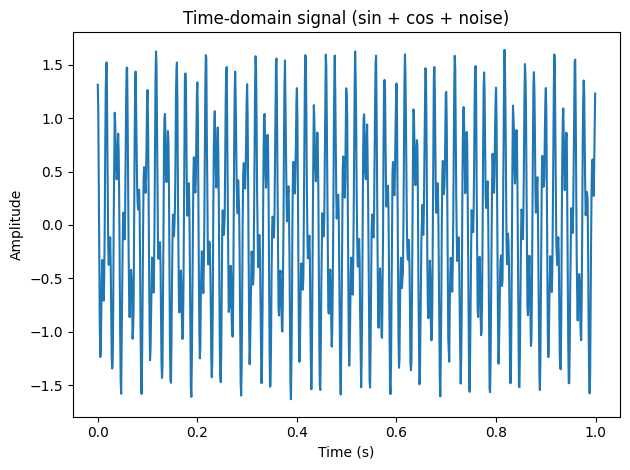

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)        # reproducible random phases
fs = 1000                 # sampling rate in Hz
T = 1.0                   # duration in seconds
N = int(fs * T)           # number of samples
t = np.linspace(0, T, N, endpoint=False)

# Signal: sine + cosine with random phase and small noise
f1 = 50   # Hz
f2 = 120  # Hz
phase1 = np.random.uniform(0, 2*np.pi)
phase2 = np.random.uniform(0, 2*np.pi)

signal = 1.0 * np.sin(2*np.pi*f1*t + phase1) + 0.6 * np.cos(2*np.pi*f2*t + phase2)
signal += 0.05 * np.random.randn(N)  # add small noise


# --- Plots ---
plt.figure()
plt.plot(t, signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time-domain signal (sin + cos + noise)")
plt.tight_layout()
plt.show()

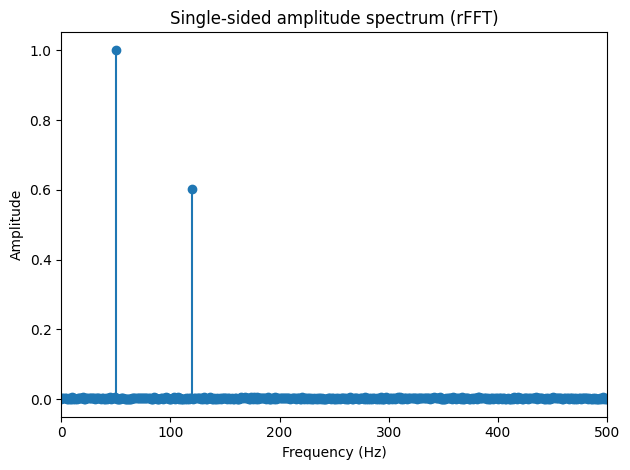

In [2]:
# FFT (single-sided)
fft_vals = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(N, 1/fs)

# Amplitude spectrum
amplitude = np.abs(fft_vals) / N
amplitude[1:-1] *= 2  # convert to single-sided amplitude

plt.figure()
plt.stem(freqs, amplitude, basefmt=" ")
plt.xlim(0, fs/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Single-sided amplitude spectrum (rFFT)")
plt.tight_layout()
plt.show()

### Step 2.1 — Creating a pulse signal  

We’ll start by generating two **1D pulse (rectangular)** signals using NumPy.  
Each pulse will have a specific width, and we’ll later convolve them to see how they interact.  

This simple signal is great for visualizing how convolution behaves with well-defined shapes.


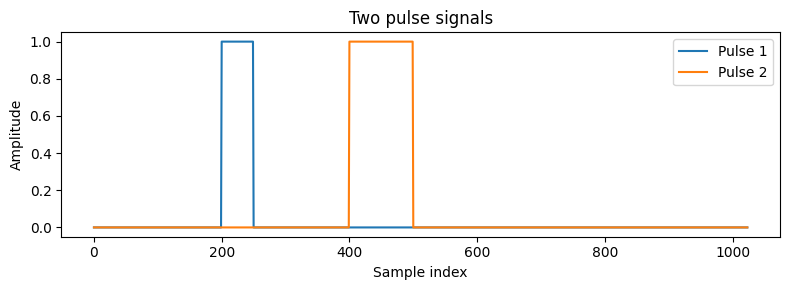

In [7]:
# Parameters
N = 1024
pulse_width1 = 50
pulse_width2 = 100

# Create pulse signals
signal1 = np.zeros(N)
signal2 = np.zeros(N)
signal1[200:200+pulse_width1] = 1
signal2[400:400+pulse_width2] = 1

# Plot
plt.figure(figsize=(8,3))
plt.plot(signal1, label="Pulse 1")
plt.plot(signal2, label="Pulse 2")
plt.legend()
plt.title("Two pulse signals")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


### Step 2.2 — Time-domain convolution with `numpy.convolve`

Now we’ll convolve the two pulse signals directly using NumPy’s built-in convolution.
We’ll also measure the computation time to see how long it takes in the time domain.

The result of convolving two rectangular pulses should form a **triangular shape**.


Time-domain convolution took 3.327 ms


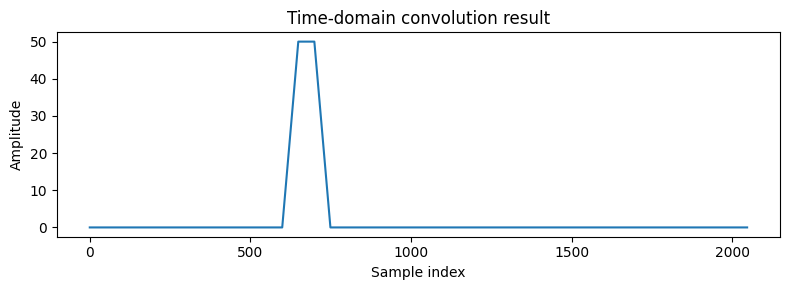

In [8]:
import time

start = time.time()
conv_time = np.convolve(signal1, signal2, mode='full')
end = time.time()

time_conv = end - start
print(f"Time-domain convolution took {time_conv*1000:.3f} ms")

plt.figure(figsize=(8,3))
plt.plot(conv_time)
plt.title("Time-domain convolution result")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


### Step 2.3 — Convolution using FFT (frequency domain)

By the **convolution theorem**, convolution in the time domain equals multiplication in the frequency domain.  
Here we:
1. Compute the FFT of both signals.
2. Multiply them element-wise in the frequency domain.
3. Apply the inverse FFT to get the convolution result.
4. Measure how much faster this approach is compared to direct convolution.

For large signals, FFT-based convolution is significantly faster.


FFT-based convolution took 2.089 ms
Speedup: 1.59x


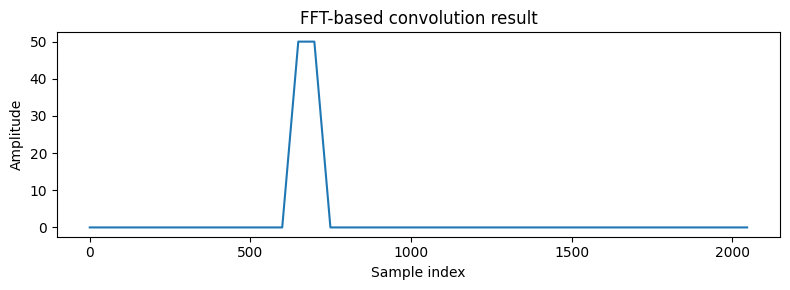

In [9]:
# FFT-based convolution
start = time.time()

# Zero-pad to the correct length (N1 + N2 - 1)
n_fft = len(signal1) + len(signal2) - 1
fft1 = np.fft.fft(signal1, n_fft)
fft2 = np.fft.fft(signal2, n_fft)
conv_fft = np.fft.ifft(fft1 * fft2).real

end = time.time()
time_fft = end - start

print(f"FFT-based convolution took {time_fft*1000:.3f} ms")
print(f"Speedup: {time_conv / time_fft:.2f}x")

plt.figure(figsize=(8,3))
plt.plot(conv_fft)
plt.title("FFT-based convolution result")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


# FFT in image

 ### Step 3 — 2D FFT on an image with and without periodic noise

In this step, we’ll:
1. Load an image (`image.png`) in **grayscale**.  
2. Compute its **2D FFT** using `numpy.fft.fft2`.  
3. Visualize:
   - the **magnitude spectrum** (log-scaled),
   - the **phase spectrum**, and
   - the **reconstructed image** from the inverse FFT.
4. Add a **periodic noise pattern** (a sinusoidal interference) to the image,  
   then repeat the same analysis (FFT, magnitude, phase, inverse).

This helps demonstrate how periodic noise appears as distinct peaks in the frequency domain.


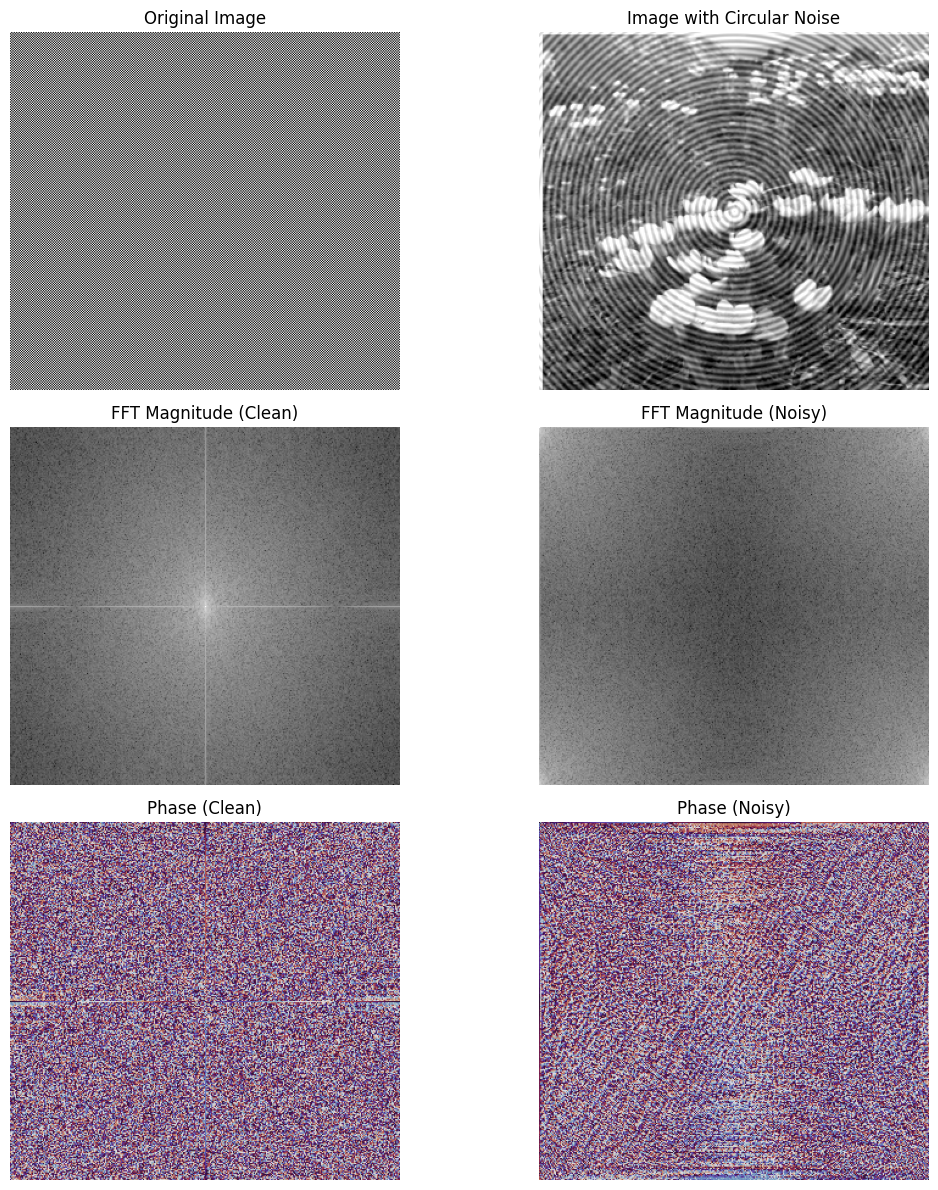

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- 1. Read image as grayscale ---
img = Image.open("image2.png").convert("L")
img_array = np.array(img, dtype=float)

rows, cols = img_array.shape
x = np.arange(cols)
y = np.arange(rows)
X, Y = np.meshgrid(x, y)

# --- 2. Create circular sinusoidal noise ---
cx, cy = cols // 2, rows // 2
R = np.sqrt((X - cx)**2 + (Y - cy)**2)
freq = 40  # number of cycles from center to edge
noise = 40 * np.sin(2 * np.pi * freq * R / np.max(R))
img_noisy = img_array + noise
img_noisy = np.clip(img_noisy, 0, 255)

# Save the noisy image
Image.fromarray(img_noisy.astype(np.uint8)).save("image_noisy_circle.png")

# --- 3. FFT ---
fft_clean = np.fft.fft2(img_array)
fft_clean_shifted = np.fft.fftshift(fft_clean)
fft_noisy_shifted = fft_clean 

fft_clean_shifted=fft_clean_shifted * fft_clean_shifted

img=np.fft.ifft2(fft_clean_shifted).real
img_array = np.array(img, dtype=float)

magnitude_clean = np.log1p(np.abs(fft_clean_shifted))
phase_clean = np.angle(fft_clean_shifted)

# fft_noisy = np.fft.fft2(img_noisy)
# fft_noisy_shifted = np.fft.fftshift(fft_noisy)

magnitude_noisy = np.log1p(np.abs(fft_noisy_shifted))
phase_noisy = np.angle(fft_noisy_shifted)

# --- 4. Plot all results ---
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Row 1: Images
axs[0,0].imshow(img_array, cmap='gray')
axs[0,0].set_title("Original Image")
axs[0,1].imshow(img_noisy, cmap='gray')
axs[0,1].set_title("Image with Circular Noise")

# Row 2: Magnitudes
axs[1,0].imshow(magnitude_clean, cmap='gray')
axs[1,0].set_title("FFT Magnitude (Clean)")
axs[1,1].imshow(magnitude_noisy, cmap='gray')
axs[1,1].set_title("FFT Magnitude (Noisy)")

# Row 3: Phases
axs[2,0].imshow(phase_clean, cmap='twilight')
axs[2,0].set_title("Phase (Clean)")
axs[2,1].imshow(phase_noisy, cmap='twilight')
axs[2,1].set_title("Phase (Noisy)")

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


75.96699455846655


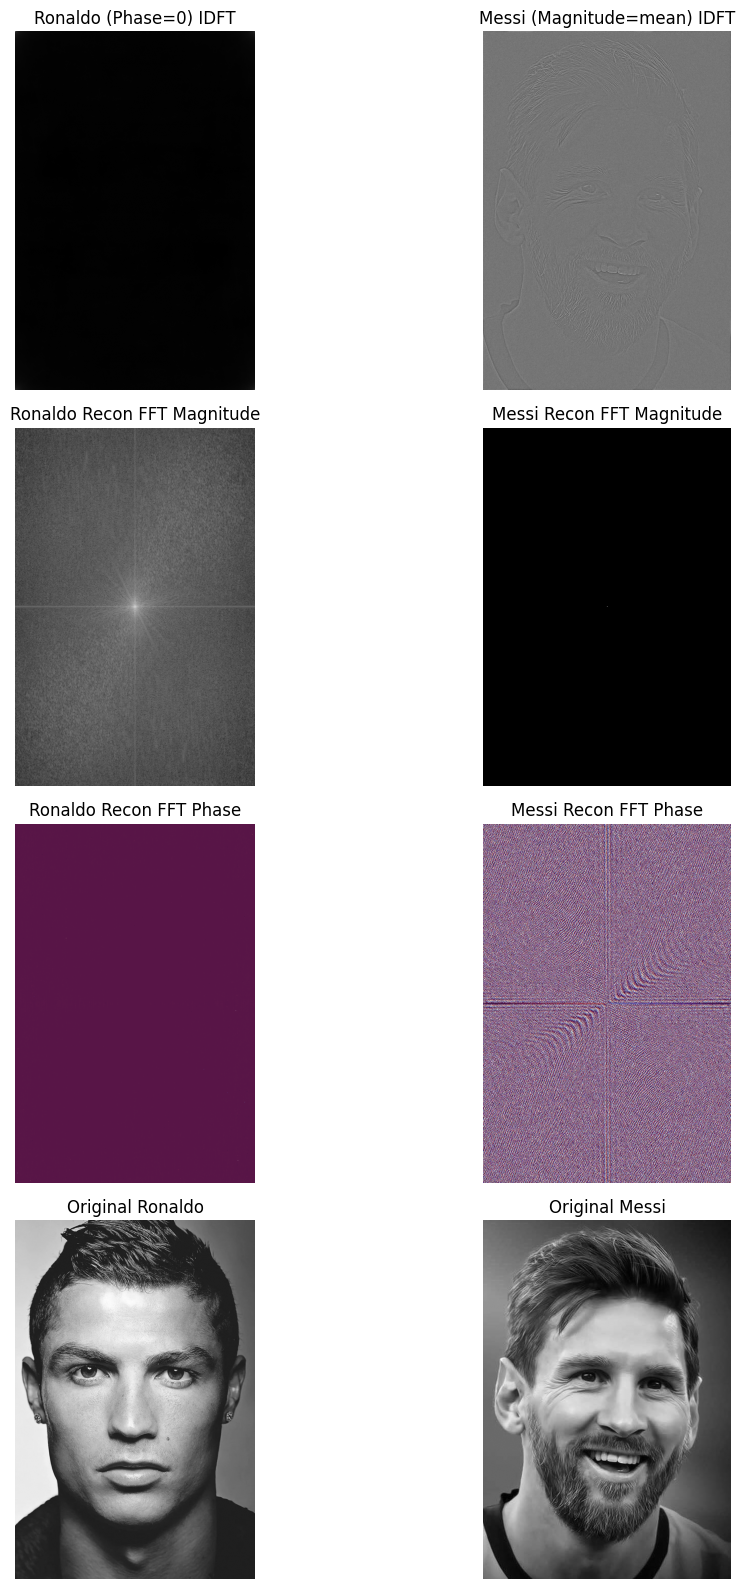

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- 1. Read images as grayscale ---
img_messi = np.array(Image.open("messi.png").convert("L"), dtype=float)
img_ronaldo = np.array(Image.open("ronaldo.png").convert("L"), dtype=float)

# --- 2. FFT of original images ---
fft_messi = np.fft.fft2(img_messi)
fft_ronaldo = np.fft.fft2(img_ronaldo)

# --- 3. Get magnitude and phase ---
mag_messi = np.abs(fft_messi)
phase_messi = np.angle(fft_messi)

mag_ronaldo = np.abs(fft_ronaldo)
phase_ronaldo = np.angle(fft_ronaldo)

# --- 4. Manipulate FFT ---

# Ronaldo: phase = 0
fft_ronaldo_new = mag_ronaldo * np.exp(1j * 0)

# Messi: keep phase, magnitude = mean
mean_mag = np.mean(mag_messi)
fft_messi_new = mean_mag * np.exp(1j * phase_messi)

# --- 5. Inverse FFT (IDFT) ---
img_ronaldo_recon = np.fft.ifft2(fft_ronaldo_new).real
img_messi_recon = np.fft.ifft2(fft_messi_new).real

# Normalize IDFT images for display
def normalize(img):
    return 255 * (img - img.min()) / np.ptp(img)

img_ronaldo_recon = normalize(img_ronaldo_recon)
img_messi_recon = normalize(img_messi_recon)

# --- 6. FFT of reconstructed images ---
def fft_mag_phase(img):
    fft = np.fft.fft2(img)
    fft_shifted = np.fft.fftshift(fft)
    magnitude = np.log1p(np.abs(fft_shifted))
    phase = np.angle(fft_shifted)
    return magnitude, phase

mag_ronaldo_recon, phase_ronaldo_recon = fft_mag_phase(img_ronaldo_recon)
mag_messi_recon, phase_messi_recon = fft_mag_phase(img_messi_recon)
print(mag_messi_recon[:3,:3].sum())

# --- 7. Plot all results ---
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Original IDFT images
axs[0,0].imshow(img_ronaldo_recon, cmap='gray')
axs[0,0].set_title("Ronaldo (Phase=0) IDFT")
axs[0,1].imshow(img_messi_recon, cmap='gray')
axs[0,1].set_title("Messi (Magnitude=mean) IDFT")

# FFT magnitude
axs[1,0].imshow(mag_ronaldo_recon, cmap='gray')
axs[1,0].set_title("Ronaldo Recon FFT Magnitude")
axs[1,1].imshow(mag_messi_recon, cmap='gray')
axs[1,1].set_title("Messi Recon FFT Magnitude")

# FFT phase
axs[2,0].imshow(phase_ronaldo_recon, cmap='twilight')
axs[2,0].set_title("Ronaldo Recon FFT Phase")
axs[2,1].imshow(phase_messi_recon, cmap='twilight')
axs[2,1].set_title("Messi Recon FFT Phase")

# Optional: original images for comparison
axs[3,0].imshow(img_ronaldo, cmap='gray')
axs[3,0].set_title("Original Ronaldo")
axs[3,1].imshow(img_messi, cmap='gray')
axs[3,1].set_title("Original Messi")

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


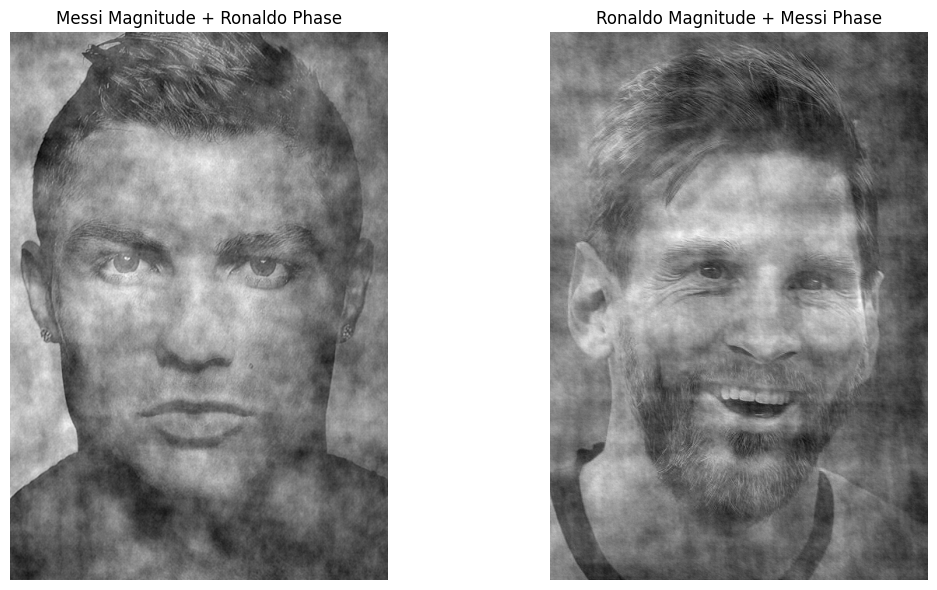

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- 1. Read images as grayscale ---
img_messi = Image.open("messi.png").convert("L")
img_ronaldo = Image.open("ronaldo.png").convert("L")

# --- 2. Rescale both images to the same size ---
# For example, resize to the size of the smaller image
rows = min(img_messi.height, img_ronaldo.height)
cols = min(img_messi.width, img_ronaldo.width)

img_messi = img_messi.resize((cols, rows))
img_ronaldo = img_ronaldo.resize((cols, rows))

# Convert to numpy arrays
img_messi = np.array(img_messi, dtype=float)
img_ronaldo = np.array(img_ronaldo, dtype=float)

# --- 3. FFT of both images ---
fft_messi = np.fft.fft2(img_messi)
fft_ronaldo = np.fft.fft2(img_ronaldo)

# --- 4. Get magnitude and phase ---
mag_messi = np.abs(fft_messi)
phase_messi = np.angle(fft_messi)

mag_ronaldo = np.abs(fft_ronaldo)
phase_ronaldo = np.angle(fft_ronaldo)

# --- 5. Create hybrid FFTs ---
fft_hybrid1 = mag_messi * np.exp(1j * phase_ronaldo)  # Messi magnitude + Ronaldo phase
fft_hybrid2 = mag_ronaldo * np.exp(1j * phase_messi)  # Ronaldo magnitude + Messi phase

# --- 6. Inverse FFT to get hybrid images ---
img_hybrid1 = np.fft.ifft2(fft_hybrid1).real
img_hybrid2 = np.fft.ifft2(fft_hybrid2).real

# --- 7. Normalize to 0-255 ---
def normalize(img):
    return 255 * (img - img.min()) / np.ptp(img)

img_hybrid1 = normalize(img_hybrid1)
img_hybrid2 = normalize(img_hybrid2)

# --- 8. Plot results ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(img_hybrid1, cmap='gray')
axs[0].set_title("Messi Magnitude + Ronaldo Phase")
axs[1].imshow(img_hybrid2, cmap='gray')
axs[1].set_title("Ronaldo Magnitude + Messi Phase")

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


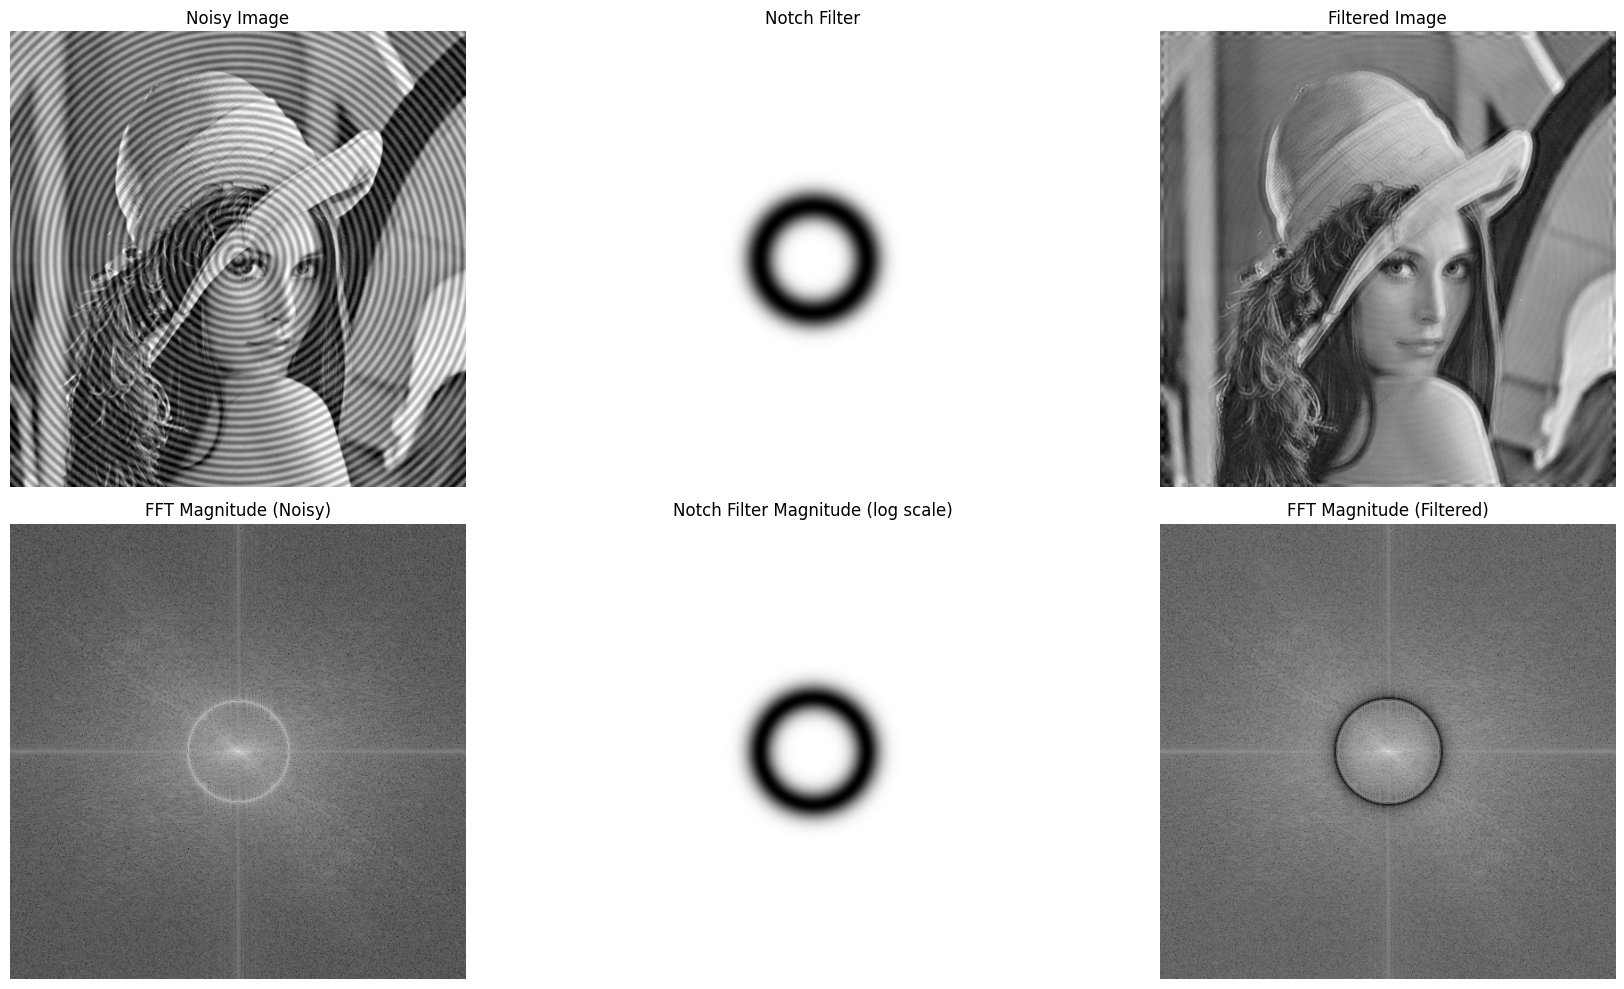

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- 1. Load images ---
img_noisy = np.array(Image.open("image_noisy_circle.png").convert("L"), dtype=float)
img_clean = np.array(Image.open("image.png").convert("L"), dtype=float)

rows, cols = img_noisy.shape
cx, cy = cols // 2, rows // 2

# --- 2. FFT of noisy image ---
fft_noisy = np.fft.fft2(img_noisy)
fft_noisy_shifted = np.fft.fftshift(fft_noisy)
magnitude_noisy = np.log1p(np.abs(fft_noisy_shifted))

# --- 3. Create circular Gaussian notch filter ---
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
R = np.sqrt((X - cx)**2 + (Y - cy)**2)

# Parameters (adjust based on noise frequency)
radius = 60   # center of the circular noise in pixels
width = 12     # smoothness of the notch
notch_filter = 1 - np.exp(-((R - radius) ** 2) / (2 * width ** 2))

# --- 4. Apply the notch filter ---
fft_filtered = fft_noisy_shifted * notch_filter
img_filtered = np.fft.ifft2(np.fft.ifftshift(fft_filtered)).real
magnitude_filtered = np.log1p(np.abs(fft_filtered))

# --- 5. Safe normalization function ---
def normalize(img):
    ptp = np.ptp(img)
    if ptp == 0:
        return np.zeros_like(img)
    return 255 * (img - img.min()) / ptp

img_noisy_norm = normalize(img_noisy)
img_filtered_norm = normalize(img_filtered)
notch_filter_norm = normalize(notch_filter)

# --- 6. Plot results ---
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Images
axs[0,0].imshow(img_noisy_norm, cmap='gray')
axs[0,0].set_title("Noisy Image")

axs[0,1].imshow(notch_filter_norm, cmap='gray')
axs[0,1].set_title("Notch Filter")

axs[0,2].imshow(img_filtered_norm, cmap='gray')
axs[0,2].set_title("Filtered Image")

# Magnitudes
axs[1,0].imshow(magnitude_noisy, cmap='gray')
axs[1,0].set_title("FFT Magnitude (Noisy)")

axs[1,1].imshow(np.log1p(np.abs(notch_filter)), cmap='gray')
axs[1,1].set_title("Notch Filter Magnitude (log scale)")

axs[1,2].imshow(magnitude_filtered, cmap='gray')
axs[1,2].set_title("FFT Magnitude (Filtered)")

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


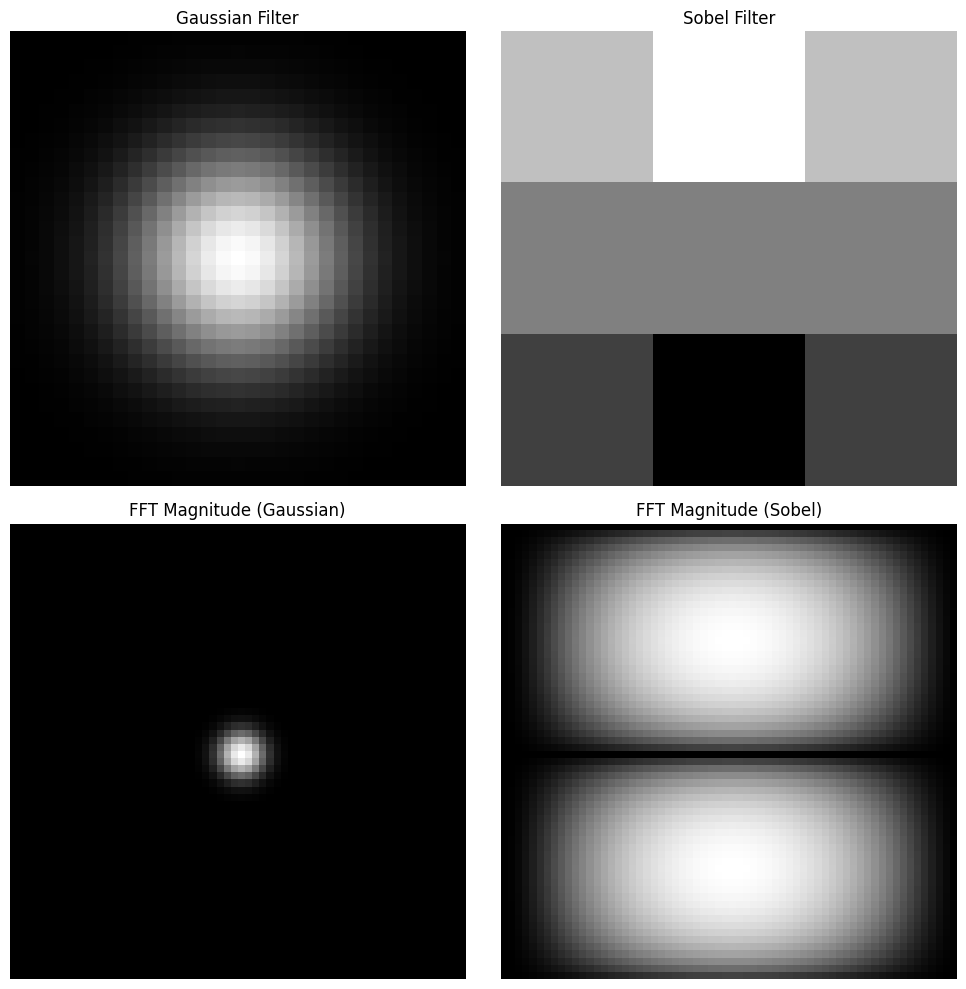

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy import signal

# --- 1. Create filters ---

# Gaussian filter
sigma = 5
size = 31  # size of filter
x = np.arange(-size//2 + 1, size//2 + 1)
X, Y = np.meshgrid(x, x)
gaussian = np.exp(-(X**2 + Y**2)/(2*sigma**2))
gaussian /= gaussian.sum()

# Sobel filter (horizontal)
sobel = np.array([[1, 2, 1],
                  [0, 0, 0],
                  [-1, -2, -1]])

# --- 2. Pad filters to larger size for FFT visualization ---
fft_size = 64
def pad_filter(filt, size):
    padded = np.zeros((size, size))
    h, w = filt.shape
    start_row = (size - h)//2
    start_col = (size - w)//2
    padded[start_row:start_row+h, start_col:start_col+w] = filt
    return padded

gaussian_padded = pad_filter(gaussian, fft_size)
sobel_padded = pad_filter(sobel, fft_size)

# --- 3. FFT and magnitude ---
def fft_mag(filter2d):
    fft = np.fft.fft2(filter2d)
    fft_shifted = np.fft.fftshift(fft)
    magnitude = np.log1p(np.abs(fft_shifted))
    return magnitude

mag_gaussian = fft_mag(gaussian_padded)
mag_sobel = fft_mag(sobel_padded)

# --- 4. Plot results ---
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original filters
axs[0,0].imshow(gaussian, cmap='gray')
axs[0,0].set_title("Gaussian Filter")
axs[0,1].imshow(sobel, cmap='gray')
axs[0,1].set_title("Sobel Filter")

# FFT magnitude
axs[1,0].imshow(mag_gaussian, cmap='gray')
axs[1,0].set_title("FFT Magnitude (Gaussian)")
axs[1,1].imshow(mag_sobel, cmap='gray')
axs[1,1].set_title("FFT Magnitude (Sobel)")

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


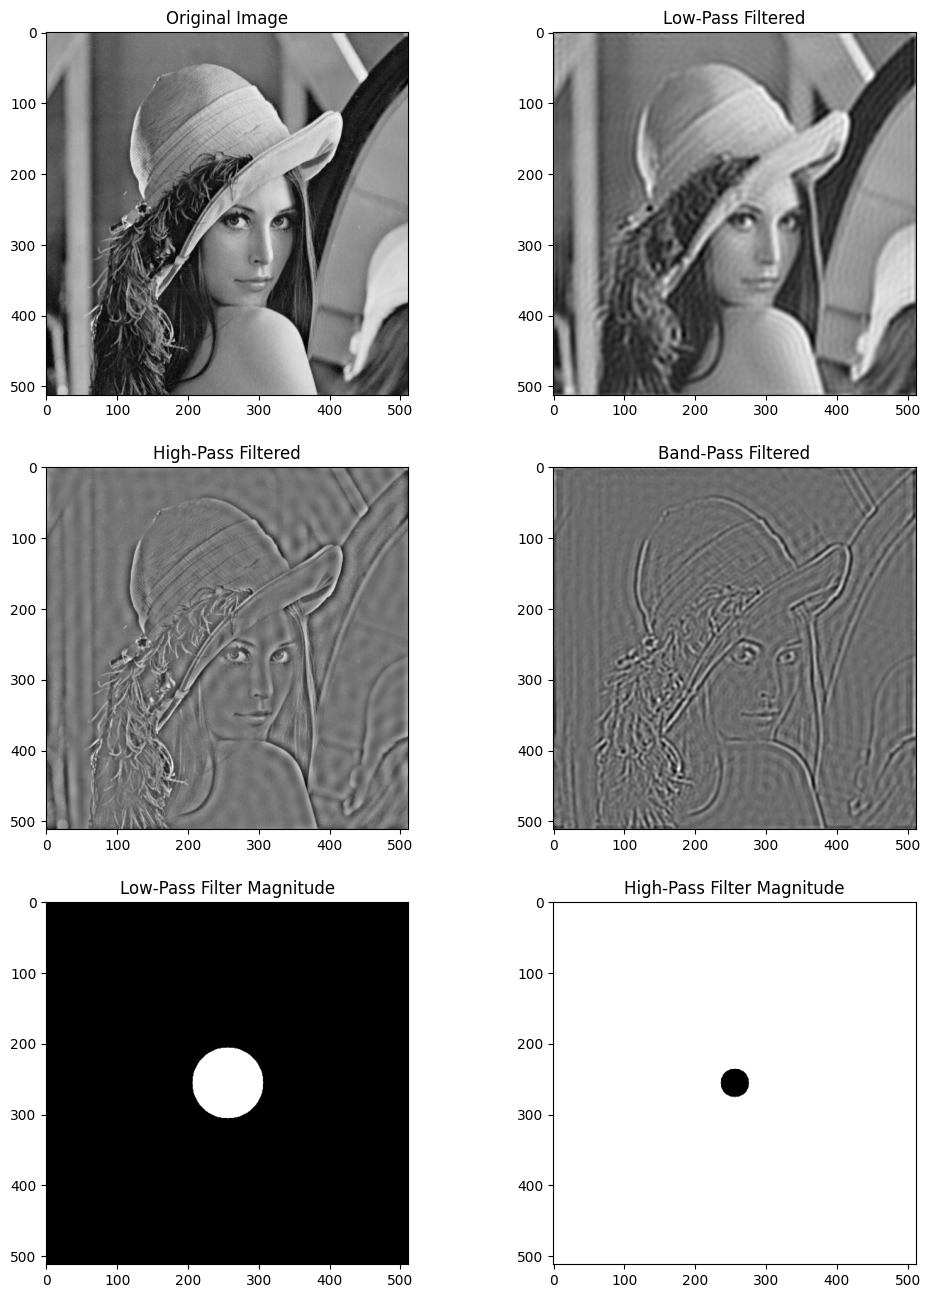

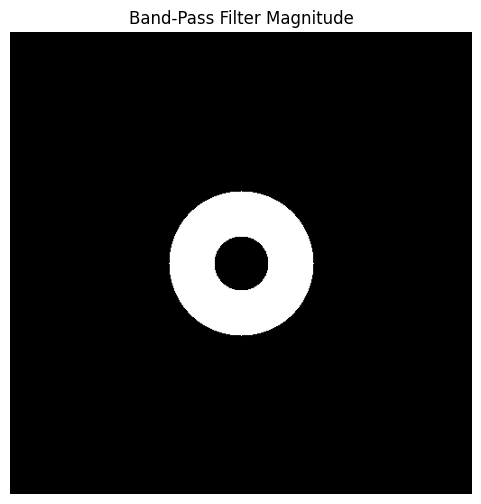

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- 1. Load image ---
img = np.array(Image.open("image.png").convert("L"), dtype=float)
rows, cols = img.shape
cx, cy = cols//2, rows//2

# --- 2. FFT of image ---
fft_img = np.fft.fft2(img)
fft_shifted = np.fft.fftshift(fft_img)

# --- 3. Create circular filters ---
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
R = np.sqrt((X - cx)**2 + (Y - cy)**2)

# Low-pass (keep low frequencies)
radius_low = 50
low_pass = np.zeros_like(img)
low_pass[R <= radius_low] = 1

# High-pass (keep high frequencies)
radius_high = 20
high_pass = np.ones_like(img)
high_pass[R <= radius_high] = 0

# Band-pass (keep mid frequencies)
radius_band_low = 30
radius_band_high = 80
band_pass = np.zeros_like(img)
band_pass[(R >= radius_band_low) & (R <= radius_band_high)] = 1

# --- 4. Apply filters ---
def apply_filter(fft_shifted, mask):
    filtered_fft = fft_shifted * mask
    filtered_img = np.fft.ifft2(np.fft.ifftshift(filtered_fft)).real
    return filtered_img

img_low = apply_filter(fft_shifted, low_pass)
img_high = apply_filter(fft_shifted, high_pass)
img_band = apply_filter(fft_shifted, band_pass)

# Normalize for display
def normalize(img):
    ptp = np.ptp(img)
    if ptp == 0:
        return np.zeros_like(img)
    return x * (img - img.min()) / ptp

img_low = normalize(img_low)
img_high = normalize(img_high)
img_band = normalize(img_band)

# Normalize filter masks for display
mag_low = normalize(low_pass)
mag_high = normalize(high_pass)
mag_band = normalize(band_pass)

# --- 5. Plot results ---
fig, axs = plt.subplots(3, 2, figsize=(12, 16))

# Original and filtered images
axs[0,0].imshow(img, cmap='gray')
axs[0,0].set_title("Original Image")
axs[0,1].imshow(img_low, cmap='gray')
axs[0,1].set_title("Low-Pass Filtered")

axs[1,0].imshow(img_high, cmap='gray')
axs[1,0].set_title("High-Pass Filtered")
axs[1,1].imshow(img_band, cmap='gray')
axs[1,1].set_title("Band-Pass Filtered")

# Filter magnitudes
axs[2,0].imshow(mag_low, cmap='gray')
axs[2,0].set_title("Low-Pass Filter Magnitude")
axs[2,1].imshow(mag_high, cmap='gray')
axs[2,1].set_title("High-Pass Filter Magnitude")

# Optional: add band-pass magnitude as separate figure
plt.figure(figsize=(6,6))
plt.imshow(mag_band, cmap='gray')
plt.title("Band-Pass Filter Magnitude")
plt.axis('off')
plt.show()

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()
